# LSTM for begginers

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter, YearLocator
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.layers import Dense, InputLayer, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

## Loading data

In [2]:
train_url='https://raw.githubusercontent.com/ShilpaSayuraML/DL-course/main/LSTM/climate_train.csv'

test_url='https://raw.githubusercontent.com/ShilpaSayuraML/DL-course/main/LSTM/climate_test.csv'

train = pd.read_csv(train_url)
test = pd.read_csv(test_url)

In [3]:
print(f"train_shape: {train.shape}")
print(f"test_shape: {test.shape}")

train_shape: (1462, 5)
test_shape: (114, 5)


In [5]:
print(test.shape[0]/(train.shape[0]+test.shape[0]))

print(train.shape[0]/(train.shape[0]+test.shape[0]))


0.07233502538071065
0.9276649746192893


## Preprocessing

In [6]:
WINDOW_SIZE = 5

In [8]:
train

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


In [9]:
def data_to_input_and_output(data):

    input_data = []
    output_data = []
    for index in range(0, len(data) - WINDOW_SIZE):
        input_sample = data['meantemp'][index:index + WINDOW_SIZE]
        output_sample = data['meantemp'][index + WINDOW_SIZE]

        input_data.append(input_sample)
        output_data.append(output_sample)

    return np.array(input_data), np.array(output_data)

In [10]:
train_input, train_output = data_to_input_and_output(train)
test_input, test_output = data_to_input_and_output(test)

In [12]:
train_input.shape

(1457, 5)

## Building and traing the neural network

In [13]:
def train_neural_network(X, y, epochs=7, learning_rate=0.005):

    model = Sequential()
    model.add(InputLayer((WINDOW_SIZE, 1)))
    model.add(LSTM(64))
    model.add(Dense(8, 'relu'))
    model.add(Dense(1, 'linear'))

    check_point = ModelCheckpoint('model/', save_best_only=True, monitor='loss')
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=learning_rate), metrics=[RootMeanSquaredError()])

    model.fit(X, y, epochs=epochs, callbacks=[check_point])
    return model

In [14]:
model = train_neural_network(train_input, train_output)

Epoch 1/7
46/46 [==============================] - 7s 107ms/step - loss: 347.4886 - root_mean_squared_error: 18.6410
Epoch 2/7
46/46 [==============================] - 4s 82ms/step - loss: 57.1053 - root_mean_squared_error: 7.5568
Epoch 3/7
46/46 [==============================] - 4s 94ms/step - loss: 29.6569 - root_mean_squared_error: 5.4458
Epoch 4/7
46/46 [==============================] - 4s 96ms/step - loss: 3.0524 - root_mean_squared_error: 1.7471
Epoch 5/7
46/46 [==============================] - 0s 5ms/step - loss: 3.0953 - root_mean_squared_error: 1.7594
Epoch 6/7
46/46 [==============================] - 0s 5ms/step - loss: 3.1839 - root_mean_squared_error: 1.7844
Epoch 7/7
46/46 [==============================] - 4s 81ms/step - loss: 3.0223 - root_mean_squared_error: 1.7385


## Predictions

In [15]:
model = load_model('model/')

In [16]:
train_pred = model.predict(train_input)
test_pred = model.predict(test_input)

4/4 [==============================] - 0s 4ms/step


In [18]:
def plot_predictions(pred, y_true, label, period):
    # Convert period to datetime if it's not already
    period = pd.to_datetime(period)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(period, y_true, label='True Values', marker='o', color='black')
    plt.plot(period, pred, label='Predictions', marker='o', color='red')

    # Adding labels and title
    plt.xlabel('Date')
    plt.ylabel('Mean temperature')
    plt.title(label)

    # Adding legend
    plt.legend()

    if label == "Train Data":
        # Format X-axis to show only years
        plt.gca().xaxis.set_major_locator(YearLocator())
        plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))
    elif label == "Test Data":
        # Format X-axis to show only months
        plt.gca().xaxis.set_major_locator(MonthLocator())
        plt.gca().xaxis.set_major_formatter(DateFormatter('%b %Y'))

    # Rotate x-axis labels for better visibility
    plt.gcf().autofmt_xdate()

    # Show the plot
    plt.show()

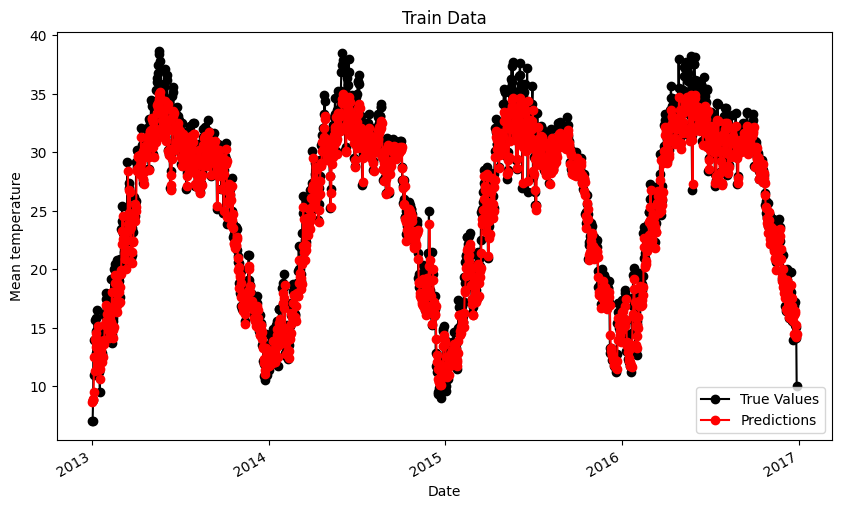

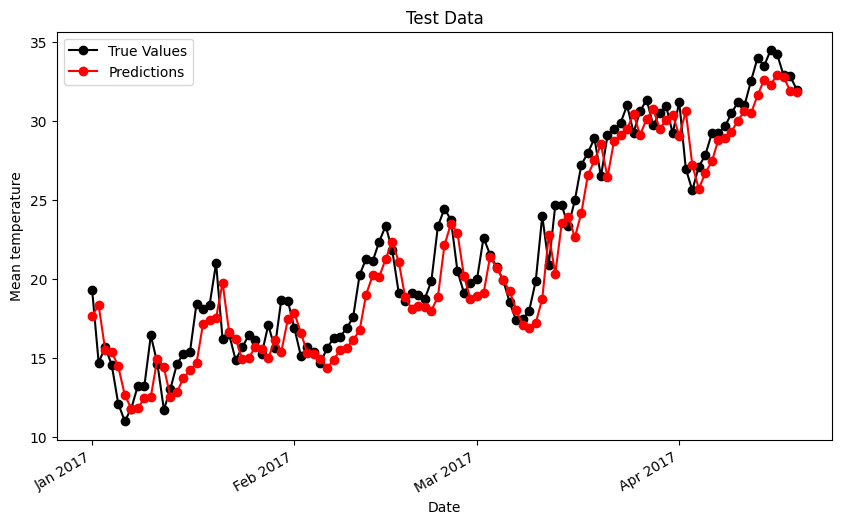

In [19]:
train_period = train[0:len(train) - WINDOW_SIZE]['date']
test_period = test[0:len(test) - WINDOW_SIZE]['date']

plot_predictions(train_pred, train_output, 'Train Data', train_period)
plot_predictions(test_pred, test_output, 'Test Data', test_period)

## How to predict the future?

In [20]:
predictions = []

def predict_the_future(input_seq, period_prediction: int = 7):
    if period_prediction == 0:
        return None
    new_prediction = model.predict(input_seq)
    predictions.append(new_prediction[0][0])

    # input_seq = [[0], [1], [2], [3], [4]]
    # prediction = [5]
    # --> new_seq = [[1], [2], [3], [4], [5]]
    new_seq = np.array([np.concatenate((input_seq[0][1:WINDOW_SIZE], new_prediction[0]))])

    predict_the_future(new_seq, period_prediction - 1)

In [21]:
seq_start = np.array([[15, 15.5, 16, 17, 18]])

if len(seq_start[0]) != WINDOW_SIZE:
    raise "Size mismatch"
predict_the_future(seq_start)

predictions

1/1 [==============================] - 0s 22ms/step


[17.073418, 16.581015, 16.160648, 15.767177, 15.366679, 14.9852495, 14.615597]